第一部分
导入我们所需要的模块
数据集下载及一些前置工作

In [1]:
import matplotlib.pyplot as plt #2D绘图库
import tensorflow as tf
import numpy as np  #用于数值矩阵计算
import time
from datetime import timedelta  #关于时间
import os

C:\WangXin\Study\Anaconda3\envs\TensorFlow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


使用sys方法导入之前的文件

In [2]:
import sys
sys.path.append(r"C:\Users\36412\Desktop\学习\deep-learning-源代码\deep-learning-源代码\deep-learning-by-example-master\Chapter09")


这些是第8章的一些文件

In [3]:
import inception
#我们可以使用该脚本下载处理过程CIFAR-10数据集
import cifar10
#导入cifar10中的num_classes方法
from cifar10 import num_classes

In [4]:
'''
将路径存入cifar10.data_path
下一行代码即：若该路径下有该文件则返回
Data has apparently already been downloaded and unpacked.
若没有则自动下载
'''
cifar10.data_path = "data/CIFAR-10/"
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


查看CIFAR10数据的分类

In [5]:
class_names = cifar10.load_class_names()

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


返回images,clss_numbers 是 整形，以及它们对应的一个-One-Hot的编码
下载训练数据：

In [6]:
training_images, training_cls_integers, trainig_one_hot_labels = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


下载测试数据：

In [7]:
testing_images, testing_cls_integers, testing_one_hot_labels = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


让我们看看CIFAR-10中训练和测试集的分布:

In [76]:
print("-Number of images in the training set:\t\t{}".format(len(training_images)))
print("-Number of images in the testing set:\t\t{}".format(len(testing_images)))

-Number of images in the training set:		50000
-Number of images in the testing set:		10000


让我们定义一些函数，使我们能够探索数据集。能在一个网格中绘制一组九幅图像:

In [9]:
def plot_imgs(imgs, true_class, predicted_class=None):
    assert len(imgs) == len(true_class)

    # 为9个字节创建一个占位符
    fig, axes = plt.subplots(3, 3) 

    # 调整间距
    if predicted_class is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # 可能只有不到9张图片，确保不会崩溃
        if i < len(imgs):
            # 画图
            ax.imshow(imgs[i],
                      interpolation='nearest')

            # 从class_names数组中获取真实类的实际名称
            true_class_name = class_names[true_class[i]]

            #显示预测类和真实类的标签
            if predicted_class is None:
                xlabel = "True: {0}".format(true_class_name)
            else:
                # 预测类的名称
                predicted_class_name = class_names[predicted_class[i]]

                xlabel = "True: {0}\nPred: {1}".format(true_class_name, predicted_class_name)

            ax.set_xlabel(xlabel)

        # 从图画中移除ticks.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

接下来：让我们继续并用图像显示一些来自测试集的图像以及它们对应的实际类:

In [10]:
# 获得测试集中的前9个图像
imgs = testing_images[0:9]

#获得真实类的整数表现形式
true_class = testing_cls_integers[0:9]

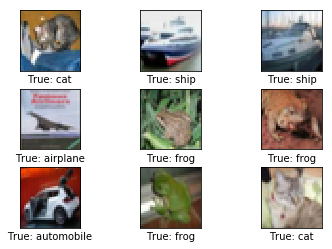

In [11]:
#画图
plot_imgs(imgs=imgs, true_class=true_class)

# 第二部分
## 接下来我们要做的是初始模型传递值




In [12]:
'''
如前所述，我们将在ImageNet数据集上使用预先训练好的初始化模型。
所以，我们需要从互联网上下载这个预先训练好的模型
'''
#下载预训练的inception v3模型
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [13]:
'''
def maybe_download():
    """
    如果还没有的话，可以从互联网上下载Inception模型
    存在于data_dir中。这个文件大约有85 MB
    """

    print("Downloading Inception v3 Model ...")
    download.maybe_download_and_extract(url=data_url, download_dir=data_dir)

'''

'\ndef maybe_download():\n    """\n    如果还没有的话，可以从互联网上下载Inception模型\n    存在于data_dir中。这个文件大约有85 MB\n    """\n\n    print("Downloading Inception v3 Model ...")\n    download.maybe_download_and_extract(url=data_url, download_dir=data_dir)\n\n'

我们将加载初始模型，以便将其用作CIFAR-10图像的特征提取器

这样我们就可以用预先训练过的权重将其最小化，并为我们的模型定制

In [14]:
inception_model = inception.Inception()

如前所述，计算CIFAR-10数据集的传输值需要一些时间，
因此我们需要将它们缓存起来以备将来使用。
值得庆幸的是，JODFQUJPO模块中有一个助手函数可以帮助我们做到这一点
接下来，我们需要为缓存的训练和测试文件设置文件路径

In [15]:
from inception import transfer_values_cache

In [16]:
file_path_train = os.path.join(cifar10.data_path, 
                               'inception_cifar10_train.pkl')
file_path_test = os.path.join(cifar10.data_path, 
                              'inception_cifar10_test.pkl')
print(file_path_train,file_path_test,sep='\n')
print("Cifar-10训练图像的初始化处理转换值…")

data/CIFAR-10/inception_cifar10_train.pkl
data/CIFAR-10/inception_cifar10_test.pkl
Cifar-10训练图像的初始化处理转换值…


In [17]:
'''
首先，我们需要缩放img来满足初始模型的要求，因为模型要求所有像素都在0到255之间，
我们的CIFAR-10像素的训练示例在0.0到1.0之间
'''
imgs_scaled = training_images * 255.0

'''
下面这个函数是检查我们的训练图像的传输值是否已经计算并加载，如果没有则计算并保存它们
'''
transfer_values_training = transfer_values_cache(cache_path=file_path_train,
                                              images=imgs_scaled,
                                              model=inception_model)

'''
与训练数据相同，首先，我们需要缩放img来满足初始模型的要求，要所有像素都在0到255之间，
我们的CIFAR-10像素的训练示例在0.0到1.0之间
'''
imgs_scaled = testing_images * 255.0

'''
检查我们的训练图像的传输值是否已经计算并加载，如果没有则计算并保存它们。
'''
transfer_values_testing = transfer_values_cache(cache_path=file_path_test,
                                             images=imgs_scaled,
                                             model=inception_model)

- Data loaded from cache-file: data/CIFAR-10/inception_cifar10_train.pkl
- Data loaded from cache-file: data/CIFAR-10/inception_cifar10_test.pkl


<hr>如前所述，在CIFAR-10数据集的训练集中，我们有50,000张图像。
<br>接下来查看这些图像的传输值的shape。在这个训练集中，应该有2048张图片

In [18]:
transfer_values_training.shape

(50000, 2048)

对测试集做同样的处理

In [19]:
transfer_values_testing.shape

(10000, 2048)

<hr>为了直观地理解传输值的外观，
我们还需要定义一个函数，来绘制我们想要查看的图
显示训练或测试集的特定图像的传输值

In [20]:
def plot_transferValues(ind):
    print("原始输入图像:")

    # 在测试集的索引处绘制图像.
    plt.imshow(testing_images[ind], interpolation='nearest')
    plt.show()

    print("使用Inception model传输值:")

    #将传输值可视化为图像.
    transferValues_img = transfer_values_testing[ind]
    transferValues_img = transferValues_img.reshape((32, 64))

    # 绘制传输值图像
    plt.imshow(transferValues_img, interpolation='nearest', cmap='Reds')
    plt.show()

原始输入图像:


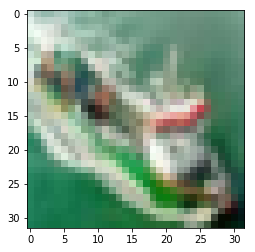

使用Inception model传输值:


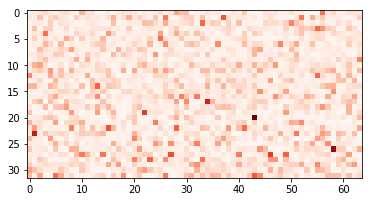

In [21]:
plot_transferValues(ind=15)

<hr> 
## 接下来进行传递值分析

在本节中，我们将对刚刚从训练图像中获得的传输值进行一些分析。<br>分析的目的是:看看这些传输值是否足以对CIFAR-10中的图像进行分类

每个输入的图像有2048个传输值。为了绘制这些传递值并对其进行进一步的分析，
我们可以使用scikit-learn中的主成分分析(PCA)等降维技术。<br>
我们将把传输值的维数从2,048减少到2，以便能够将其可视化，
并看看它们是否适合用于区分不同类别的cifar 10

In [22]:
from sklearn.decomposition import PCA

接下来，我们需要创建一个PCA对象，其中组件的数量只有2个

In [23]:
pca_obj = PCA(n_components=2)

将传输值从2048减少到2需要很多时间，<br>
所以我们只要对50000张图像中的3000张进行子集划分即可：

In [24]:
subset_transferValues = transfer_values_training[0:3000]

得到这些图片的类号:

In [25]:
cls_integers = testing_cls_integers[0:3000]

我们可以通过打印传输值的Shape来再次检查这个子集是否正确划分:
## 第一种降维方法

In [26]:
subset_transferValues.shape

(3000, 2048)

接下来，我们使用PCA对象将传输值从2,048减少到2:

In [27]:
reduced_transferValues = pca_obj.fit_transform(subset_transferValues)

In [28]:
reduced_transferValues.shape

(3000, 2)

在将传递值的维数降为2之后，让我们绘制这些值

In [29]:
#导入颜色映射图，以用不同的颜色绘制每个类。
import matplotlib.cm as color_map

In [30]:
def plot_reduced_transferValues(transferValues, cls_integers):
    #为每一个类创建一个颜色不同的颜色图
    c_map = color_map.rainbow(np.linspace(0.0, 1.0, num_classes))

    # 获得每个样本的颜色
    colors = c_map[cls_integers]

    # 获得X,y的值
    x_val = transferValues[:, 0]
    y_val = transferValues[:, 1]

    # 在散点图中绘制传输值
    plt.scatter(x_val, y_val, color=colors)
    plt.show()


在这里，我们将绘制训练集中子集的转移值。<br>我们在CIFAR-10中有10个类，所以我们将用不同的颜色绘制它们对应的转移值。<br>如下图所示，<br>传输值根据相应的类进行分组。<br>组间重叠是因为PCA的约简过程不能正确分离传递值:

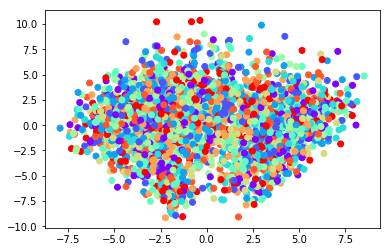

In [31]:
plot_reduced_transferValues(reduced_transferValues, cls_integers)

<hr>接下来这是另一种降维数方法：<br>使用另一种名为t-SNE的降维方法进一步分析传递值:

In [32]:
from sklearn.manifold import TSNE

这一次，我们要降低传递值的维数，但最终降到50而不是之前的2：
## 第二种降维方法

In [33]:
pca_obj = PCA(n_components=50)
transferValues_50d = pca_obj.fit_transform(subset_transferValues)
#.fit_transform<==>先调用fit 再调用transform
# fit方法的主要工作是获取特征信息和目标值信息
# transform方法主要用来对特征进行转换

In [34]:
transferValues_50d.shape

(3000, 50)

<hr><hr>接下来，我们再叠加到要使用的新降维技术里，将PCA过程的输出输入到里面:

In [35]:
tsne_obj = TSNE(n_components=2) #n_components设置为2，也就是将多维矩阵降到2维
reduced_transferValues = tsne_obj.fit_transform(transferValues_50d) 

再检查一下它的形状是否正确

In [36]:
reduced_transferValues.shape

(3000, 2)

<hr>再使用t-SNE方法绘制减小后的传递值。<br>如下图所示，t-SNE能够比PCA更好地分离分组传输值。<br>从这个分析中则可得出的结论：我们通过将输入的图像输入到预训练的初始模型中而得到的传输值可以用来将训练图像分离到10个类中。<br>从下图中可以看到少许重叠，所以这种分离不是100%准确的。<br>但是我们可以通过对预先训练好的模型进行微调来消除这种重叠:

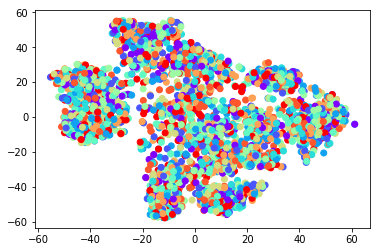

In [37]:
plot_reduced_transferValues(reduced_transferValues, cls_integers)

### 现在我们有了从训练图像中提取的传输值
<br>我们知道这些值在某种程度上能够区分CIFAR-10的不同类。<br>接下来，我们需要构建一个线性分类器，并将这些传递值提供给它来执行实际的分类。
#### 创建分离器，进行分类

## 模型和训练
### 模型

因此，让我们从指定输入占位符变量开始，这些变量将被输入到神经网络模型中。<br>第一个输入变量的形状（将包含提取的传输值）是[None,transfer_len]。<br>第二占位符变量将以一个One-Hot格式保存训练集的实际类标签。

In [38]:
transferValues_arrLength = inception_model.transfer_len   # 第14行对实例inception_modeld使用其中的transfer_len属性
# tensorflow的设计理念称之为计算流图，在编写程序时，首先构筑整个系统的graph，代码并不会直接生效，这一点和python的其他数值计算库
# （如Numpy等）不同，graph为静态的。然后，在实际的运行时，启动一个session，程序才会真正的运行。
# 这样做的好处就是：避免反复地切换底层程序实际运行的上下文，tensorflow帮你优化整个系统的代码。我们知道，很多python程序的底层为
# C语言或者其他语言，执行一行脚本，就要切换一次，是有成本的，tensorflow通过计算流图的方式，帮你优化整个session需要执行的代码，
# 还是很有优势的。
# 所以placeholder()函数是在神经网络构建graph的时候在模型中的占位，此时并没有把要输入的数据传入模型，它只会分配必要的内存。
# 等建立session，在会话中，运行模型的时候通过feed_dict()函数向占位符喂入数据
# 所有关于图变量的赋值和计算都要通过tf.Session的run来进行

input_values = tf.placeholder(tf.float32, shape=[None, transferValues_arrLength], 
                              name='input_values')
y_actual = tf.placeholder(tf.float32, shape=[None, num_classes], 
                          name='y_actual')
type(y_actual)

tensorflow.python.framework.ops.Tensor

我们还可以通过定义另一个占位符变量，得到每个类的对应整数值（从1到10):

In [39]:
y_actual_cls = tf.argmax(y_actual, axis=1)
# 返回的是y_actual中的最大值的索引号，如果y_actual是一个向量，那就返回一个值，如果是一个矩阵，那就返回一个向量，
# 这个向量的每一个维度都是相对应矩阵行的最大值元素的索引号

In [40]:
'''
解释：
''' 
A = [[1,3,4,5,6]]
B = [[1,3,4], [2,4,1]]
 
with tf.Session() as sess:
    print(sess.run(tf.argmax(A, 1)))
    print(sess.run(tf.argmax(B, 1)))

[4]
[2 1]


而我们需要构建一个实际的分类神经网络来获取这些输入的占位符并生成预测类:

In [41]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05)) 
    # tf.Variable(initializer,name),参数initializer是初始化参数，name是可自定义的变量名称,返回一个张量
        # 使用Variable（）创建的变量可以用作图中其他操作的输入

    # tf.truncated_normal(shape, mean, stddev) :shape表示生成张量的维度，mean是均值，stddev是标准差。
    # 这个函数产生正太分布，均值和标准差自己设定,最终返回一个shape维的随机数
    
    #  tf.constant(value,dtype=None,shape=None,name=’Const’) 
#     创建一个常量tensor，按照给出value来赋值，用shape来指定其形状。value可以是一个数，也可以是一个list。
    # tensor 是张量即N维数组
#     如果是一个数，那么这个常量中所有值得按该数来赋值。 
#     如果是list,那么len(value)一定要小于等于shape展开后的长度。赋值时，先将value中的值逐个存入。不够的部分，
#     则全部存入value的最后一个值。

In [42]:
ab = tf.Variable(tf.constant(0.05, shape=[10]),name='ab')
cd = tf.Variable(tf.constant(0.05, shape=[10,2]),name='ab')
ef = tf.Variable(initial_value=0,
                          name='step', trainable=False)
gh = tf.truncated_normal([4,2],mean=1,stddev=0.05)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) #这行代码的官方解释是 初始化模型的参数
    print('ab: {}'.format(sess.run(ab)))
    print('cd: {}'.format(sess.run(cd)))
    print('ef: {}'.format(sess.run(ef)))
    print('gh: {}'.format(sess.run(gh)))

ab: [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05]
cd: [[0.05 0.05]
 [0.05 0.05]
 [0.05 0.05]
 [0.05 0.05]
 [0.05 0.05]
 [0.05 0.05]
 [0.05 0.05]
 [0.05 0.05]
 [0.05 0.05]
 [0.05 0.05]]
ef: 0
gh: [[1.0065348  1.0376278 ]
 [0.9659973  1.0463276 ]
 [1.0320997  1.0491649 ]
 [1.0274178  0.97174495]]


In [43]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))



In [44]:
def new_fc_layer(input,          # 
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # 创建新的权重和偏差值
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # 计算该层作为输入和权重的矩阵乘法，然后添加偏值。
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

第一个 全连接层

In [45]:
layer_fc1 = new_fc_layer(input=input_values,
                             num_inputs=2048,
                             num_outputs=1024,
                             use_relu=True)

第二个 fully-connected 层

In [46]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                             num_inputs=1024,
                             num_outputs=num_classes,
                             use_relu=False)

预测类标签：

In [47]:
y_predicted = tf.nn.softmax(layer_fc2) #将其值压缩到0-1之间

每个图像分类的交叉熵：

In [48]:
cross_entropy = \
    tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                labels=y_actual)
# 在计算loss的时候，最常见的一句话就是tf.nn.softmax_cross_entropy_with_logits，

# 首先明确一点，loss是代价值，也就是我们要最小化的值

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### tf.nn.softmax_cross_entropy_with_logits(logits, labels, name=None)
除去name参数用以指定该操作的name，与方法有关的一共两个参数：<br>
第一个参数logits：就是神经网络最后一层的输出，如果有batch的话，它的大小就是[batchsize，num_classes]，单样本的话，大小就是num_classes
<br>执行流程大概分为两步：

第一步:是先对网络最后一层的输出做一个softmax，这一步通常是求取输出属于某一类的概率，对于单样本而言，输出就是一个num_classes大小的向量（[Y1，Y2,Y3...]其中Y1，Y2，Y3...分别代表了是属于该类的概率）


第二步:是softmax的输出向量[Y1，Y2,Y3...]和样本的实际标签做一个交叉熵


注意！！！这个函数的返回值并不是一个数，而是一个向量，如果要求交叉熵，我们要再做一步tf.reduce_sum操作,就是对向量里面所有元素求和，最后才得到，如果求loss，则要做一步tf.reduce_mean操作，对向量求均值！

<hr>损失 aka. 成本计量<br>
这是必须最小化的标量值:


In [49]:
loss = tf.reduce_mean(cross_entropy)

模型建立好了

然后，我们需要定义一个优化准则，用于分类器的训练。在这个实现中，我们将使用AdamOptimizer。<br>实现Adam的优化器<br>这个分类器的输出将是一个含10个概率值的数组，对应于CIFAR-10数据集中的类数。<br>然后，我们将对这个数组应用argmax操作，将最大得分的类分配给这个输入示例:

In [50]:
step = tf.Variable(initial_value=0,
                          name='step', trainable=False)
step

<tf.Variable 'step_1:0' shape=() dtype=int32_ref>

In [51]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, step)
# 使用minimize()操作，该操作不仅可以优化更新训练的模型参数，也可以为全局步骤(global step)计数。
# 这些训练操作都需要在tf.session会话中进行

In [52]:
y_predicted_cls = tf.argmax(y_predicted, axis=1)
#比较预测类和真实类
correct_prediction = tf.equal(y_predicted_cls, y_actual_cls)
#tf.equal(A, B)是对比这两个矩阵或者向量的相等的元素，如果是相等的那就返回True，反正返回False，返回的值的矩阵维度和A是一样的

In [53]:
'''
tf.eqyal测试:
'''
A = [[1,3,4,5,6]]
B = [[1,3,4,3,2]]
 
with tf.Session() as sess:
    print(sess.run(tf.equal(A, B)))

[[ True  True  True False False]]


In [54]:
#将boolean值转化为float
'''
tf.reduce_mean操作，对向量求均值
tf.cast(x,y)将x的数据格式转化成y
'''
model_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

接下来，我们需要定义一个将实际执行图形的TensorFlow的session，<br>然后初始化我们在此实现中早先定义的变量:

In [55]:
session = tf.Session()
session.run(tf.global_variables_initializer())

在这个实现中，我们将使用随机梯度下降(SGD)，因此我们需要定义一个函数来从50,000张图像的训练集中随机生成特定大小的批。<br>
从而，将再定义一个函数，用于从传输值的输入训练集生成一个<br>
#### 成一个随机批进行处理:


<hr>定义训练批次的大小:

In [56]:
training_batch_size = 32

定义一个从数据集中随机选择一批图像的函数:

In [57]:
def select_random_batch():
    # 训练集中的图像数（传输值）
    num_imgs = len(transfer_values_training) #第17行代码 所储存的 训练图像的传输值

    # 创建一个随机索引.
    '''
    np.random.choice
    
    a1 = np.random.choice(a=5, size=3, replace=False, p=None)
    参数意思分别 是从a 中以概率P，随机选择3个, p没有指定的时候相当于是一致的分布
    replace是是否有放回抽样
    '''
    ind = np.random.choice(num_imgs,
                           size=training_batch_size,
                           replace=False)
    #使用随机索引去选择一些随机的 X 和 y 的值
    #我们用transfer-values代替 图像作为 x-values
    x_batch = transfer_values_training[ind]
    y_batch = trainig_one_hot_labels[ind]

    return x_batch, y_batch

接下来，我们需要定义一个函数来执行实际的优化过程，这将优化网络的权重。<br>它将在每次迭代中生成一个批处理，并根据该批处理优化网络:

In [58]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # 随机的选一批图像去训练
        # 在input_batch中存储图像传输值
        # 其他图像的真实值将会储存在y_actual_batch
        input_batch, y_actual_batch = select_random_batch()

        # 存储这批数据在一个字典里再给它取一个适当的名字
        # 像我们在上面定义且输入的占位符变量
        feed_dict = {input_values: input_batch,
                     y_actual: y_actual_batch}
       

        # 现在我们调用这批图像的优化器
        # TensorFlow 将自动提供我们上面创建的dict的值
        # 在我们上面定义的模型输入占位符变量.
        '''
        feed_dict的作用是给使用placeholder创建出来的tensor赋值
        当我们构建完图后，需要在一个会话中启动图，启动的第一步是创建一个Session对象。

        为了取回操作的输出内容, 可以在使用 Session 对象的 run()调用执行图时，传入一些 tensor, 这些 tensor 会帮助你取回结果。
        '''
        i_global, _ = session.run([step, optimizer],
                                  feed_dict=feed_dict)

        # 打印每100步的精度
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # 计算在training_batch中的精确值.
            batch_accuracy = session.run(model_accuracy,
                                         feed_dict=feed_dict)

            msg = "Step: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_accuracy))

In [59]:
msg = "Step: {0:>6}, Training Accuracy: {1:>6.1%}"
print(msg.format('1',100))

Step:      1, Training Accuracy: 10000.0%


我们将定义一些函数来显示前一个神经网络的结果，并显示预测结果的混淆矩阵:

In [60]:
def plot_errors(cls_predicted, cls_correct):
    # cls_predicted 是一个数组它里面是测试集中所有图像的预测类

    # #cls_correct 是一个具有布尔值的数组，用于指示模型是否预测了正确的类

    # 否定布尔数组
    incorrect = (cls_correct == False)

    # 从测试集中获得图片是False的分类

    incorrectly_classified_images = testing_images[incorrect]

    # #从那些图片中获得预测类
    cls_predicted = cls_predicted[incorrect]

    # 从那些图像获得真实的类
    true_class = testing_cls_integers[incorrect]

    n = min(9, len(incorrectly_classified_images))

    # 画第一个 n 图像
    plot_imgs(imgs=incorrectly_classified_images[0:n],
              true_class=true_class[0:n],
              predicted_class=cls_predicted[0:n])

In [61]:
([True,True,False,False]== False)


False

In [62]:
([True,True,True,True]== True)


False

接下来，我们需要定义辅助函数来绘制混淆矩阵:<br>
导入绘制混淆矩阵的方法：

In [63]:
from sklearn.metrics import confusion_matrix

In [64]:
def plot_confusionMatrix(cls_predicted):

 
    #在 test 中的所有预测类编号的 cls_predicted 数组
    # 从 sklearn 调用混淆矩阵
    cm = confusion_matrix(y_true=testing_cls_integers,
                          y_pred=cls_predicted)

    # 打印混淆矩阵
    for i in range(num_classes):
        # 将类名附加到每一行
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # 用类号标记混淆矩阵的每一列
    cls_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(cls_numbers))

In [65]:
'''
for循环列表的意义：
'''
a = ['({})'.format(i) for i in range(10)]
print(a)
print("".join(a))

['(0)', '(1)', '(2)', '(3)', '(4)', '(5)', '(6)', '(7)', '(8)', '(9)']
(0)(1)(2)(3)(4)(5)(6)(7)(8)(9)


另外，再定义另一个函数，这个函数将经过训练的分类器应用在测试集上，并测量经过训练的模型应用在测试集上的准确性:

In [66]:
#将数据集分批分类，以限制RAM的使用
batch_size = 128

In [67]:
def predict_class(transferValues, labels, cls_true):
    # Number of images.
    num_imgs = len(transferValues)

    #为预测类分配一个数组，这些类将分批计算并填充到这个数组中
    '''
    np.zeros返回来一个给定形状和类型的用0填充的数组
    '''
    cls_predicted = np.zeros(shape=num_imgs, dtype=np.int)

    #现在计算批次的预测类，我们将遍历所有批次，

    i = 0

    while i < num_imgs:
        # 下一批结束指标记为j
        j = min(i + batch_size, num_imgs)

        # 用索引i 和j之间的图像和标签创建一个feed-dict
        feed_dict = {input_values: transferValues[i:j],
                     y_actual: labels[i:j]}

        # 使用TensorFlow计算预测类
        cls_predicted[i:j] = session.run(y_predicted_cls, feed_dict=feed_dict)

        # 将下一批的开始索引设置为当前批的结束索引
        i = j

    # 创建一个布尔数组，每一个图像是否正确分类
    '''
    zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表
    '''
    correct = [a == p for a, p in zip(cls_true, cls_predicted)]


    print(type(correct))

    return correct, cls_predicted


调用之前的函数对test做预测:

In [68]:
def predict_class_test():
    return predict_class(transferValues = transfer_values_testing,
                       labels = trainig_one_hot_labels,
                       cls_true = training_cls_integers)

In [69]:
def classification_accuracy(correct):
    #定平均一个布尔数列时，False代表0，True代表1。
    #所以我们在计算：True/len(correct) 的个数，这和分类精度是一样的

    #返回这个分类精度，和正确分类数量

    return np.mean(correct), np.sum(correct)

In [70]:
def test_accuracy(show_example_errors=False,
                  show_confusion_matrix=False):
    #再测试集中的所有数据，计算预测类和是否他们正确
    correct, cls_pred = predict_class_test()

    print(type(correct))

    #分类 accuracy predict_class_test 和正确分类数量
    accuracy, num_correct = classification_accuracy(correct)

    #正确分类图像的数量
    num_images = len(correct)

    # Print the accuracy.
    msg = "Test set accuracy: {0:.1%} ({1} / {2})"
    print(msg.format(accuracy, num_correct, num_images))

     #画一些mis-classifications的例子，若需要的话
    if show_example_errors:
        print("Example errors:")
        plot_errors(cls_predicted=cls_pred, cls_correct=correct)

    #画混淆矩阵，如果需要的话
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusionMatrix(cls_predicted=cls_pred)

在进行任何优化之前，让我们看看前面的神经网络模型的性能:

<class 'list'>
<class 'list'>
Test set accuracy: 9.4% (941 / 10000)
Example errors:


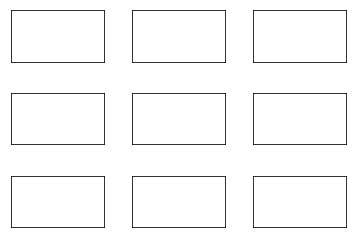

Confusion Matrix:
[ 19  12  69  90  46 745  18   1   0   0] (0) airplane
[ 68   0  97  84  54 678  10   9   0   0] (1) automobile
[ 33  30  47 373  53 438  20   6   0   0] (2) bird
[ 32  18 151 240  73 474  12   0   0   0] (3) cat
[ 21   6  84 403  64 407  14   1   0   0] (4) deer
[ 55   8 121 238  89 458  27   0   0   4] (5) dog
[ 10   7 149 228  44 526  34   1   0   1] (6) frog
[ 13   8  77 287 199 398  15   3   0   0] (7) horse
[ 23   1  35  44  34 848   2  13   0   0] (8) ship
[ 19   1 266 133  93 483   5   0   0   0] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [71]:
test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

<hr>正如你所看到的，网络的性能非常低，但是在基于我们已经定义的优化标准进行一些优化之后，它会变得更好。<br>因此，接下来，我们运行优化器进行1000次迭代，然后测试模型的准确性:

In [72]:
optimize(num_iterations=1000)

Step:    100, Training Accuracy:  90.6%
Step:    200, Training Accuracy:  84.4%
Step:    300, Training Accuracy:  87.5%
Step:    400, Training Accuracy:  84.4%
Step:    500, Training Accuracy:  93.8%
Step:    600, Training Accuracy:  93.8%
Step:    700, Training Accuracy:  96.9%
Step:    800, Training Accuracy:  84.4%
Step:    900, Training Accuracy:  87.5%
Step:   1000, Training Accuracy:  90.6%


<class 'list'>
<class 'list'>
Test set accuracy: 10.2% (1024 / 10000)
Example errors:


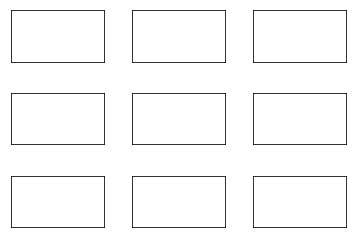

Confusion Matrix:
[876   9  18   6   4   2   2   3  68  12] (0) airplane
[  9 942   1   5   1   1   0   1  12  28] (1) automobile
[ 23   1 841  41  42  11  26  11   4   0] (2) bird
[  9   0  12 824  19  75  30  17   8   6] (3) cat
[ 12   0  28  20 848  11  29  48   3   1] (4) deer
[  2   0  12 107  14 828   6  28   2   1] (5) dog
[  3   2  18  41  21  10 900   2   3   0] (6) frog
[  9   0   5  28  26  25   0 899   6   2] (7) horse
[ 25   6   0   3   0   0   0   1 959   6] (8) ship
[ 12  64   2   4   0   1   1   3  21 892] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [73]:
test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [ ]:
model.close()
session.close()

